In [123]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.api import qqplot
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

## Wczytanie danych

In [124]:
file_path = 'city_temperature.csv'
data = pd.read_csv(file_path,low_memory=False)
data['AvgTemperature_C'] = (data['AvgTemperature'] - 32) * 5 / 9 

### Wybór roku i miasta

In [125]:
city = "Ulan-bator"

start_year = 2015
end_year = 2016

city_data = data[(data['City'] == city) & (data['Year'] >= start_year) & (data['Year'] <= end_year + 1)]
city_data = np.array(city_data['AvgTemperature_C'])

print(len(city_data))


1097


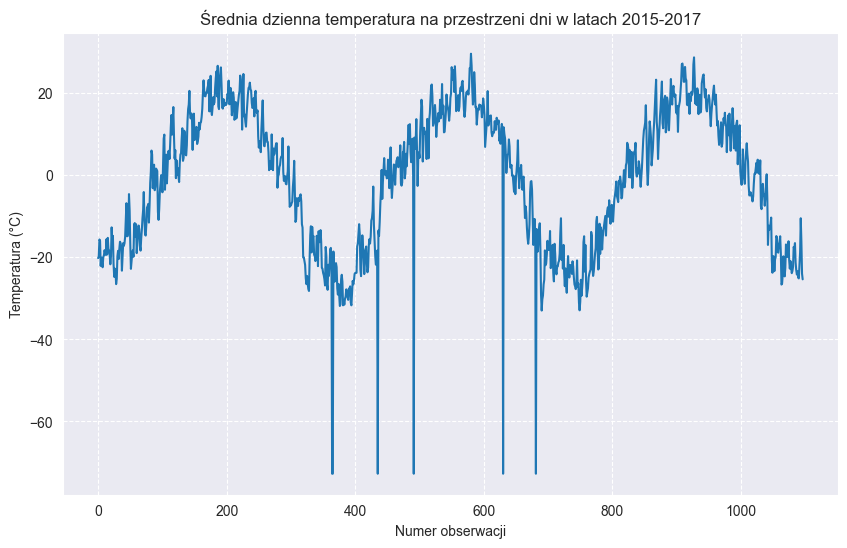

In [126]:
plt.figure(figsize=(10, 6))
plt.plot(city_data)
plt.xlabel('Numer obserwacji')
plt.ylabel('Temperatura (°C)')
plt.title(f'Średnia dzienna temperatura na przestrzeni dni w latach {start_year}-{end_year + 1}')
plt.grid(linestyle = '--')
plt.savefig("dane_surowe.png")
plt.show()

## Czyszczenie danych

In [127]:
def data_cleaner(data,t_min):
    for i in range(len(data)):
        if data[i] < t_min:
            data[i] = data[i-1]
    return data

In [128]:
city_data = data_cleaner(city_data,-40)

## Wizualizacja danych

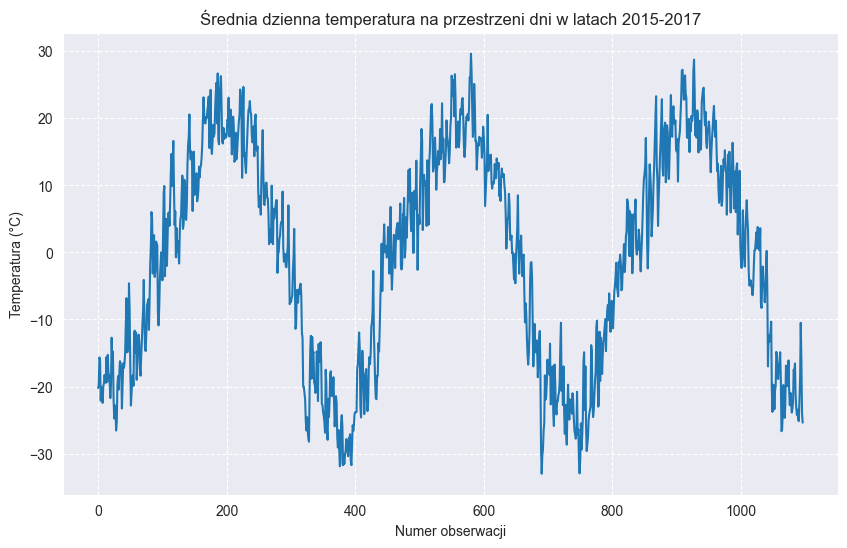

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(city_data)
plt.xlabel('Numer obserwacji')
plt.ylabel('Temperatura (°C)')
plt.title(f'Średnia dzienna temperatura na przestrzeni dni w latach {start_year}-{end_year + 1}')
plt.grid(linestyle = '--')
plt.show()

In [130]:
n = 365
future_data = city_data[-n:]
city_data = city_data[:-n]

## Podział na zbiór ćwiczeniowy i testowy

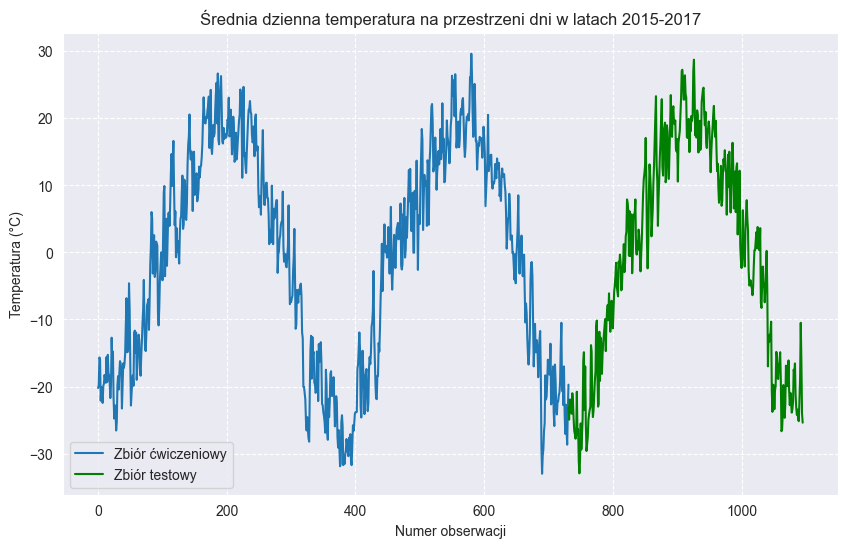

In [131]:
t1 = np.arange(len(city_data)-1,len(city_data)-1 + n,1)

plt.figure(figsize=(10, 6))
plt.plot(city_data, label = 'Zbiór ćwiczeniowy')
plt.plot(t1,future_data, label = 'Zbiór testowy',c = 'g')
plt.xlabel('Numer obserwacji')
plt.ylabel('Temperatura (°C)')
plt.title(f'Średnia dzienna temperatura na przestrzeni dni w latach {start_year}-{end_year + 1}')
plt.legend()
plt.grid(linestyle = '--')
plt.savefig("dane_podzielone.png")
plt.show()

## Stacjonarność dla danych surowych

In [132]:
# Przeprowadzamy test ADF na danych city_data
result = adfuller(city_data)

# Wyświetlamy wyniki testu
print("Statystyka testu ADF:", result[0])
print("P-value:", result[1])
print("Liczba opóźnień użytych w modelu:", result[2])
print("Liczba obserwacji w użytej próbce:", result[3])
print("Wartości krytyczne:")
for key, value in result[4].items():
    print(f'   {key}: {value}')

Statystyka testu ADF: -1.5700731271313075
P-value: 0.4986070283644955
Liczba opóźnień użytych w modelu: 7
Liczba obserwacji w użytej próbce: 724
Wartości krytyczne:
   1%: -3.4394144152232995
   5%: -2.8655403100177566
   10%: -2.5689002207655443


## Wykres ACF dla oryginalnych danych

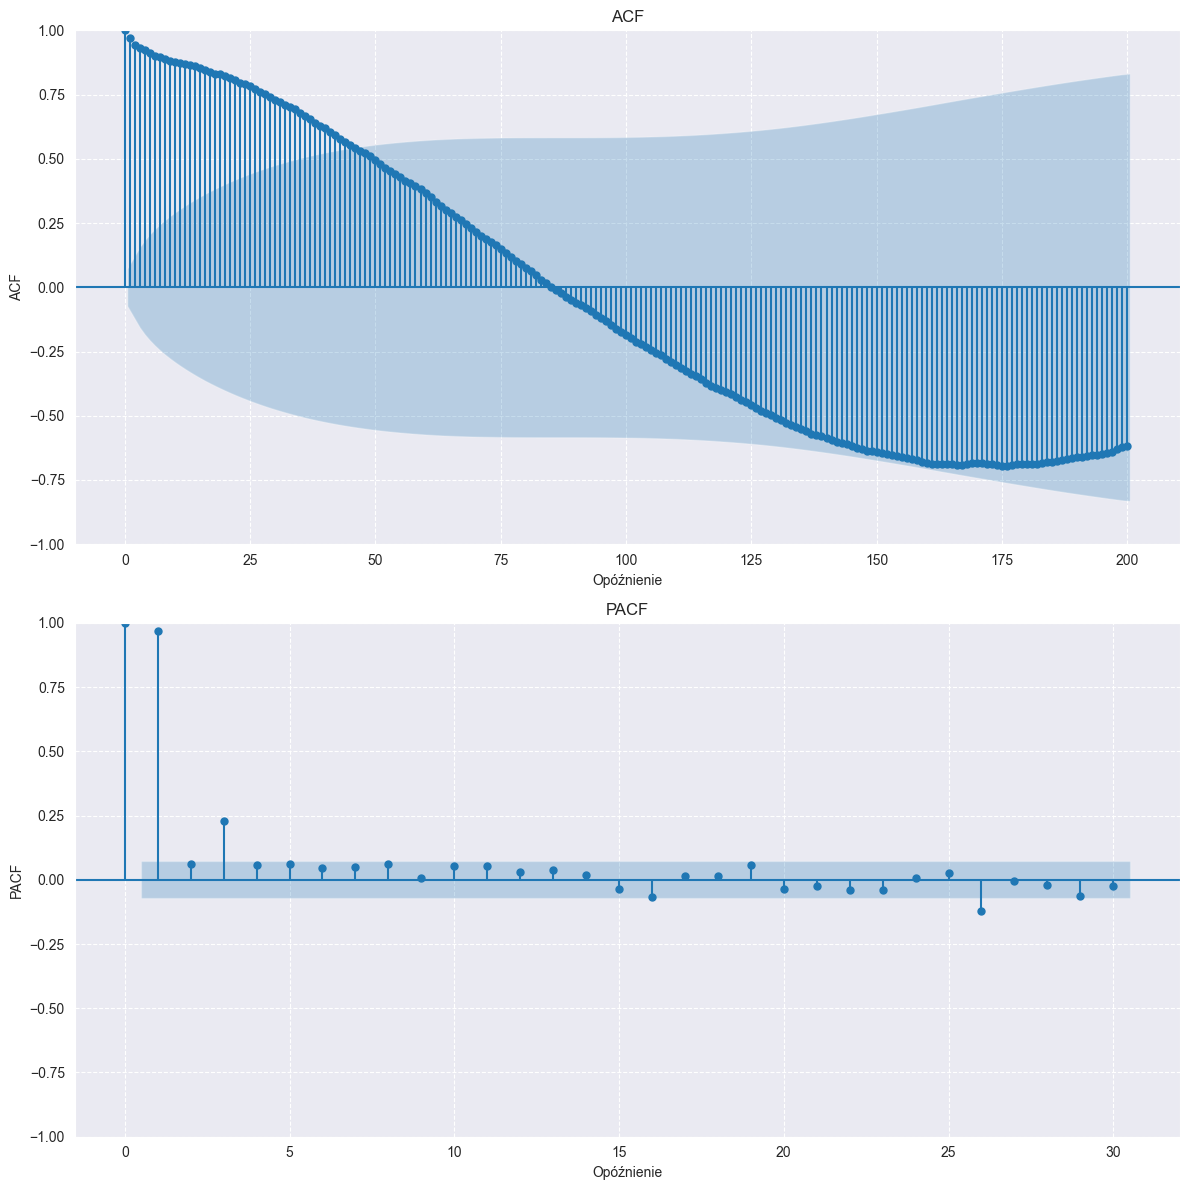

In [133]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # 2 wiersze, 1 kolumna

# Wykres ACF
plot_acf(city_data, lags=200, ax=axes[0])  # Przypisanie wykresu do pierwszej osi
axes[0].set_title("ACF")
axes[0].set_xlabel("Opóźnienie")  # Etykieta osi X dla ACF
axes[0].set_ylabel("ACF")         # Etykieta osi Y dla ACF
axes[0].grid(linestyle='--')

# Wykres PACF
plot_pacf(city_data, lags=30, ax=axes[1])  # Przypisanie wykresu do drugiej osi
axes[1].set_title("PACF")
axes[1].set_xlabel("Opóźnienie")  # Etykieta osi X dla PACF
axes[1].set_ylabel("PACF")        # Etykieta osi Y dla PACF
axes[1].grid(linestyle='--')

# Automatyczne dopasowanie układu i wyświetlenie
plt.savefig("PACF_ACF_surowe.png")
plt.tight_layout()
plt.show()

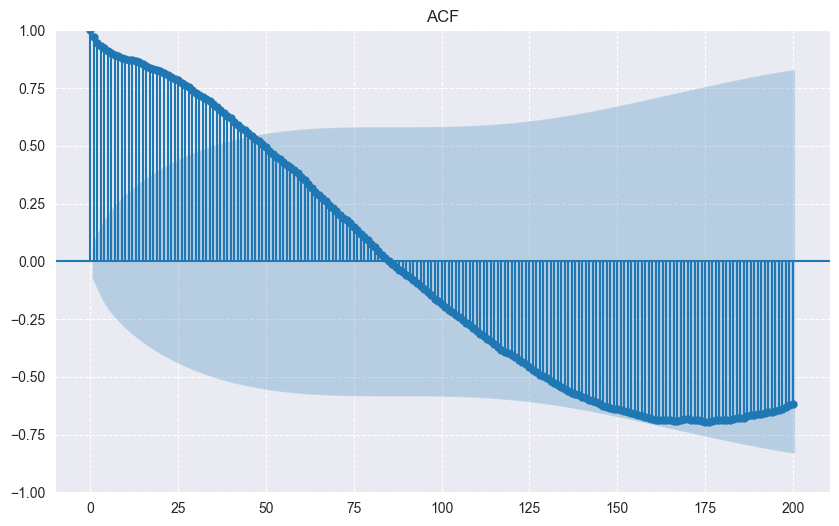

In [134]:
plt.rc("figure",figsize=(10, 6) )
plot_acf(city_data, lags = 200)
plt.title("ACF")
plt.grid(linestyle = '--')
plt.savefig("ACF_surowe.png")
plt.show()

## Wykres PACF dla oryginalnych danych

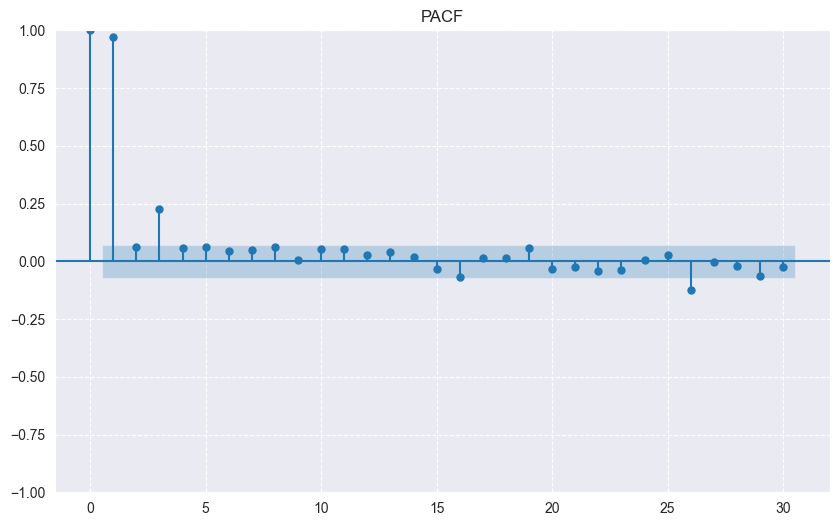

In [135]:
plt.rc("figure",figsize=(10, 6) )
plot_pacf(city_data, lags=30)
plt.title("PACF")
plt.grid(linestyle = '--')
plt.savefig("PACF_surowe.png")
plt.show()

## Usuwanie trendu

#### (1) Szereg fouriera

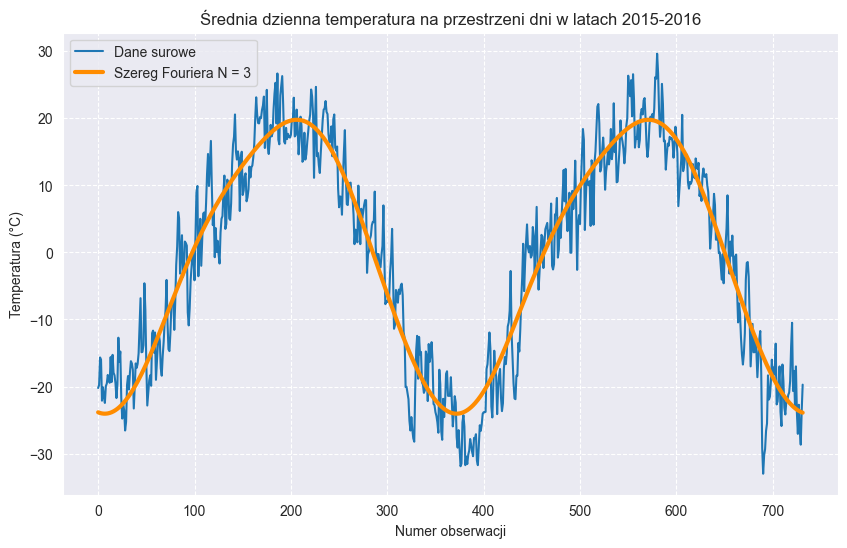

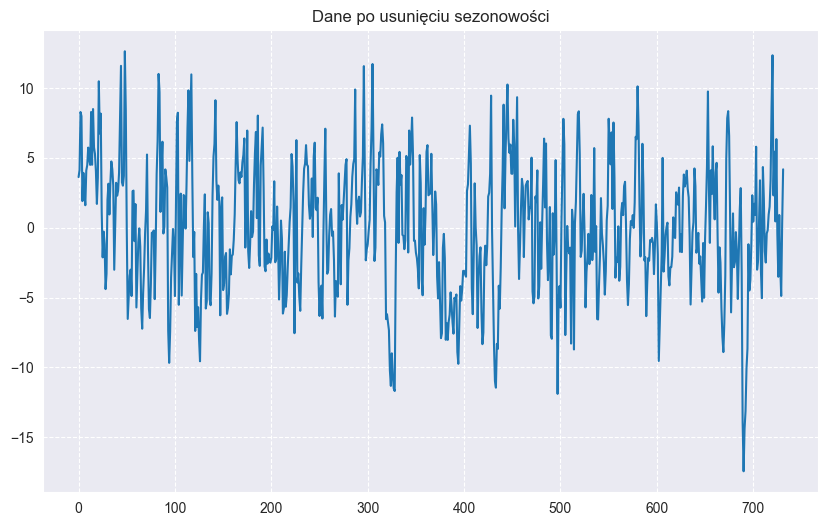

In [136]:
from sklearn.linear_model import LinearRegression

t = np.arange(len(city_data))

# Liczba harmonicznych (im więcej, tym bardziej złożona sezonowość)
k = 3  # Liczba harmonicznych (do dopasowania złożonej sezonowości)

# Macierz cech Fouriera
X_fourier = np.column_stack(
    [
        np.sin(2 * np.pi * t * i / 365) for i in range(1, k + 1)
    ] + [
        np.cos(2 * np.pi * t * i / 365) for i in range(1, k + 1)
    ]
)

# Dopasowanie modelu regresji do danych
model = LinearRegression()
model.fit(X_fourier, city_data)

# Oszacowanie sezonowości
seasonal = model.predict(X_fourier)

plt.plot(city_data, label = "Dane surowe")
plt.plot(seasonal,c='darkorange', label = f"Szereg Fouriera N = {k}",linewidth = 3)
plt.grid(linestyle = '--')
plt.xlabel('Numer obserwacji')
plt.ylabel('Temperatura (°C)')
plt.title(f'Średnia dzienna temperatura na przestrzeni dni w latach {start_year}-{end_year}')
plt.legend()
plt.savefig("sezonowosc.png")
plt.show()

city_data = city_data - seasonal

plt.plot(city_data)
plt.grid(linestyle = '--')
plt.title("Dane po usunięciu sezonowości")
plt.show()

Transformata Boxa Coxa

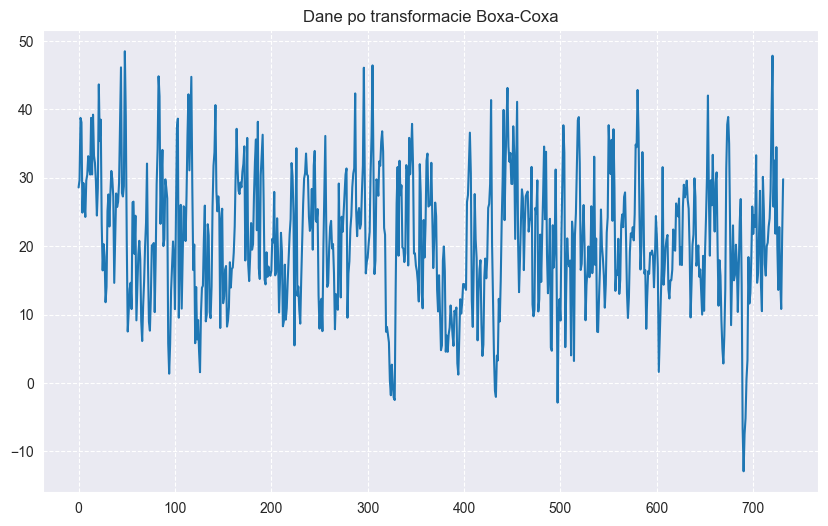

In [137]:
from scipy.stats import boxcox

def inv_boxcox(data,lambd):
    if lambd == 0:
        return np.exp(data)
    else:
        return np.power((data*lambd)+1, 1/lambd)

city_data += 30

city_data, lambda_ = boxcox(city_data)

city_data -= 30

plt.plot(city_data)
plt.grid(linestyle = '--')
plt.title("Dane po transformacie Boxa-Coxa")
plt.savefig("dane_stacjonarne.png")
plt.show()

Prosta regresji

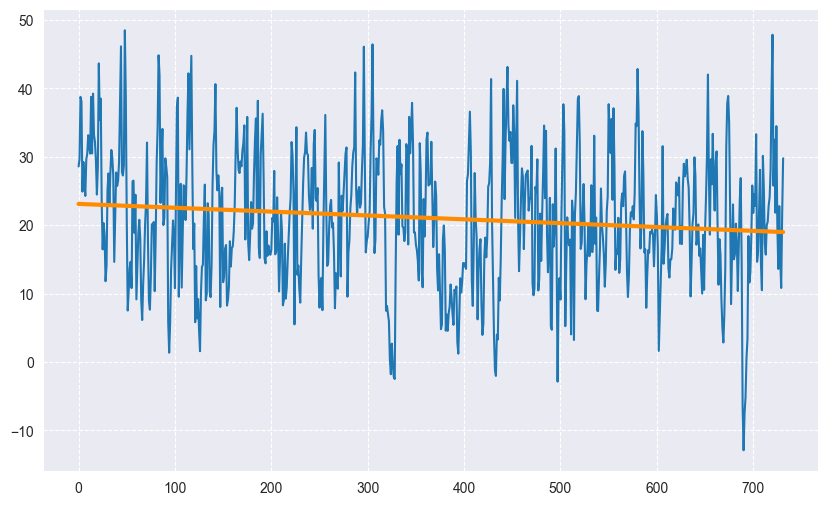

In [138]:
t = np.arange(0,len(city_data),1)
lin = np.polyfit(t,city_data,deg=1)
y_lin = np.polyval(lin,t)

plt.figure(figsize=(10, 6))
plt.plot(t,city_data)
plt.plot(t,y_lin,c ='darkorange',linewidth = 3)
plt.grid(linestyle = '--')
plt.show()

city_data -= y_lin

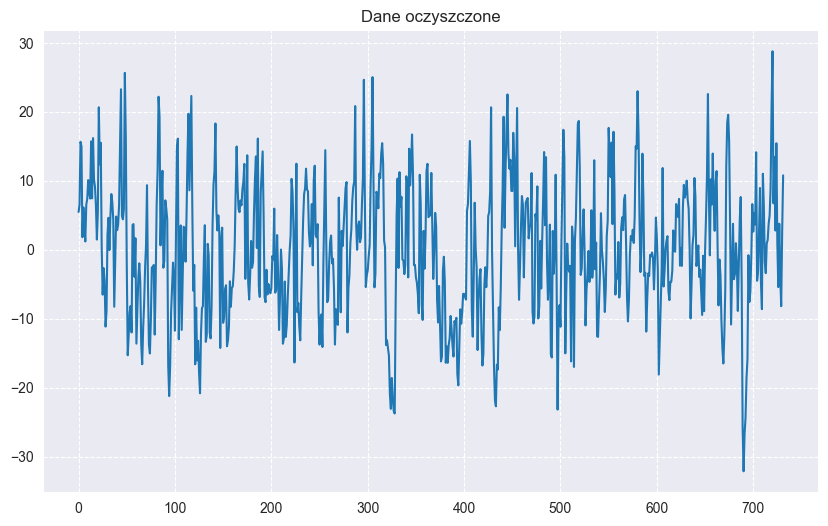

In [139]:
plt.plot(city_data)
plt.grid(linestyle = '--')
plt.title("Dane oczyszczone")
plt.savefig("dane_stacjonarne.png")
plt.show()

Sprawdzenie punktu zmiany reżimu

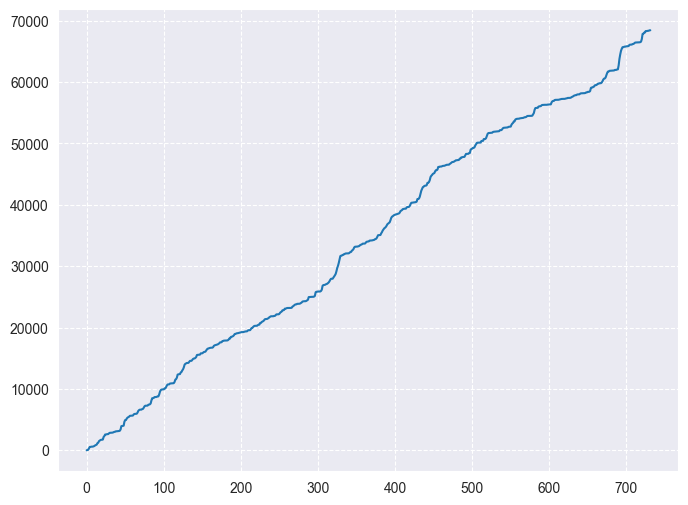

In [140]:
Cm = np.zeros(len(city_data))
for i in range(len(city_data)):
    Cm[i] = np.sum((city_data[:i])**2)



plt.figure(figsize=(8,6))
plt.plot(Cm)
# plt.plot([500,500],[0,3500])
plt.grid(linestyle = '--')
plt.show()

In [141]:
K = []
k = 30
V = []

for i in range(k,998):
    K.append(i)
    C1 = Cm[:i]
    C2 = Cm[i:]
    X1 = np.linspace(0,len(C1),len(C1))
    X2 = np.linspace(len(C1),1000,len(C2))
    b1, b0 = np.polyfit(t,city_data,deg=1)
    a1, a0 = np.polyfit(t,city_data,deg=1)
    V.append(np.sum((C1-(b0+b1*X1))**2)+np.sum((C2-(a0+a1*X2))**2))

k = K[np.argmin(V)]

print(k)

34


## ACF i PACF dla danych z usunięciem trendu i sezonowości

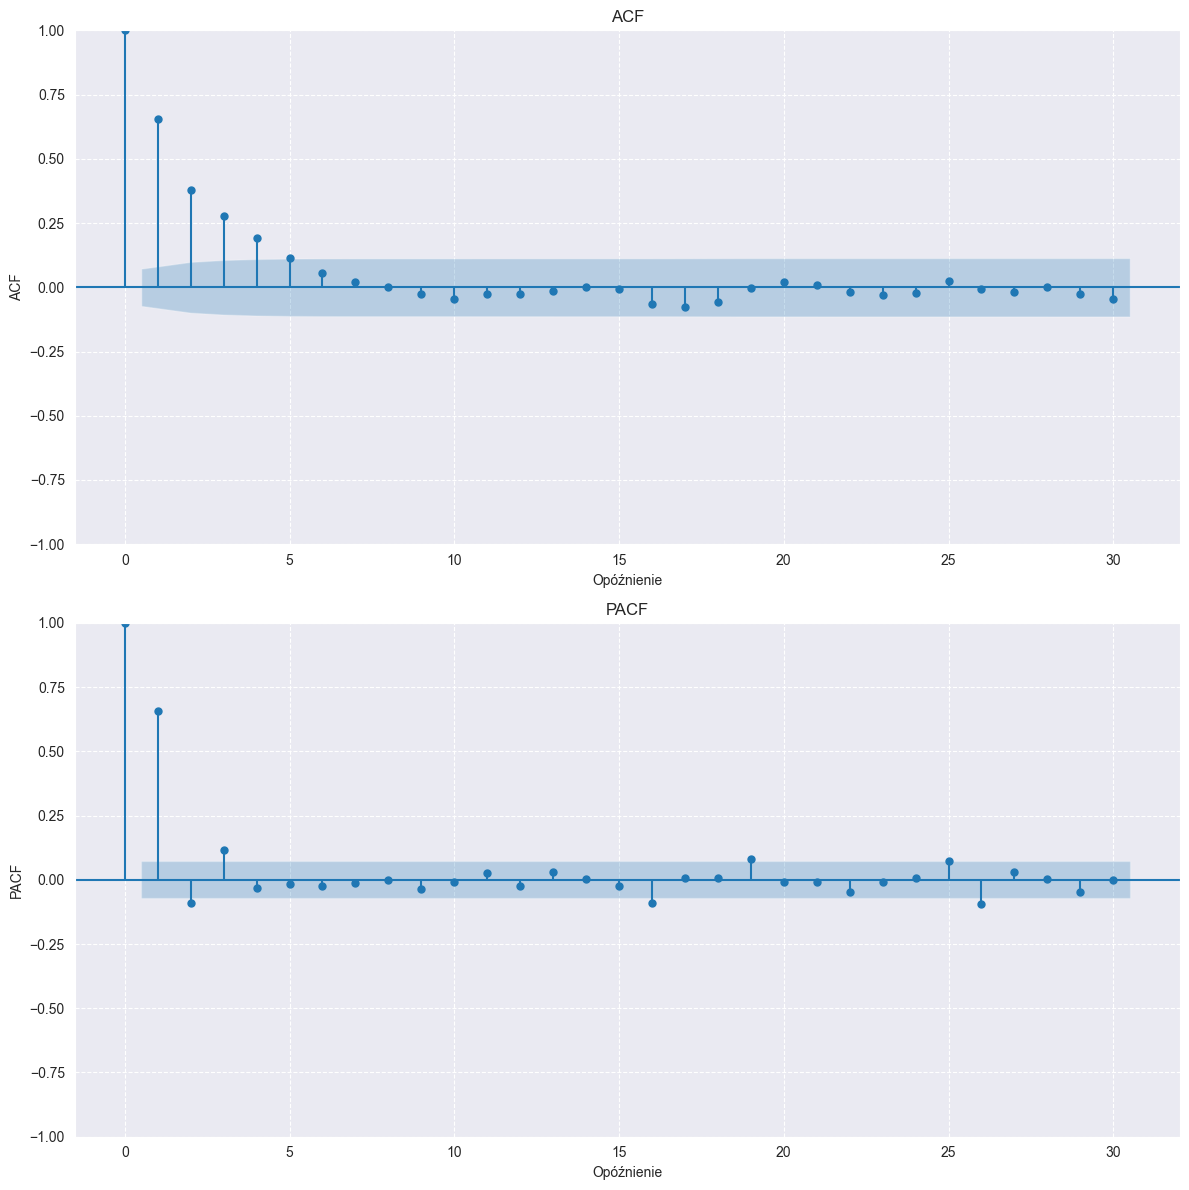

In [142]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # 2 wiersze, 1 kolumna

# Wykres ACF
plot_acf(city_data, lags=30, ax=axes[0])  # Przypisanie wykresu do pierwszej osi
axes[0].set_title("ACF")
axes[0].set_xlabel("Opóźnienie")  # Etykieta osi X dla ACF
axes[0].set_ylabel("ACF")         # Etykieta osi Y dla ACF
axes[0].grid(linestyle='--')

# Wykres PACF
plot_pacf(city_data, lags=30, ax=axes[1])  # Przypisanie wykresu do drugiej osi
axes[1].set_title("PACF")
axes[1].set_xlabel("Opóźnienie")  # Etykieta osi X dla PACF
axes[1].set_ylabel("PACF")        # Etykieta osi Y dla PACF
axes[1].grid(linestyle='--')

# Automatyczne dopasowanie układu i wyświetlenie
plt.savefig("PACF_ACF_stacjonarne.png")
plt.tight_layout()
plt.show()

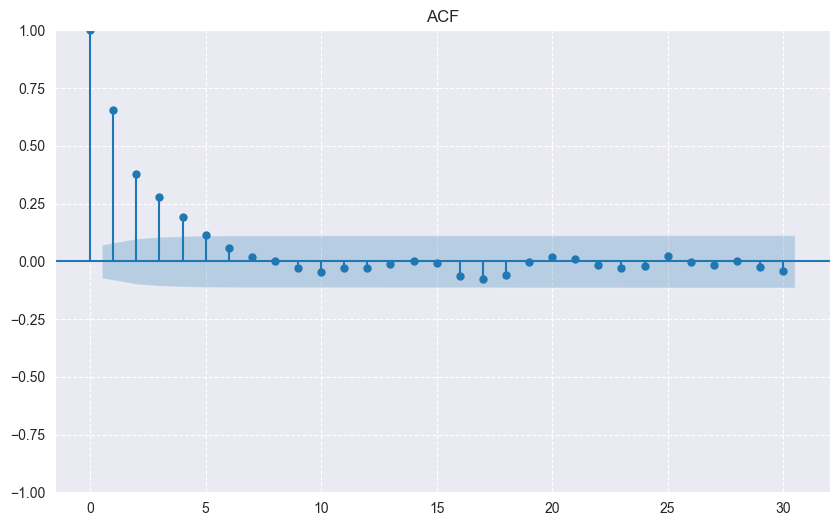

In [143]:
plt.rc("figure",figsize=(10, 6) )
plot_acf(city_data, lags = 30)
plt.title("ACF")
plt.grid(linestyle = '--')
plt.savefig("ACF_stacjonarne.png")
plt.show()

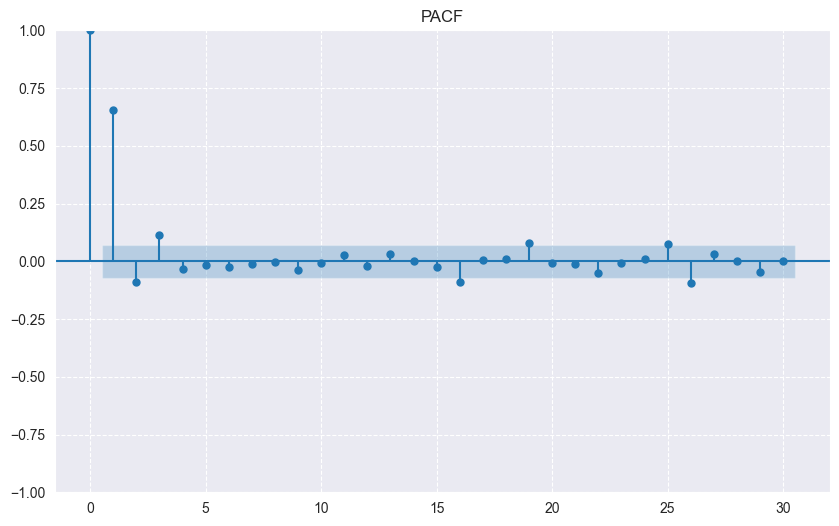

In [144]:
plt.rc("figure",figsize=(10, 6) )
plot_pacf(city_data, lags=30)
plt.title("PACF")
plt.grid(linestyle = '--')
plt.savefig("PACF_stacjonarne.png")
plt.show()

## Sprawdzenie stacjonarności modelu

In [145]:
from statsmodels.tsa.stattools import adfuller

# Przeprowadzamy test ADF na danych city_data
result = adfuller(city_data)

# Wyświetlamy wyniki testu
print("Statystyka testu ADF:", result[0])
print("P-value:", result[1])
print("Liczba opóźnień użytych w modelu:", result[2])
print("Liczba obserwacji w użytej próbce:", result[3])
print("Wartości krytyczne:")
for key, value in result[4].items():
    print(f'   {key}: {value}')

Statystyka testu ADF: -9.948413631322417
P-value: 2.5528338288310326e-17
Liczba opóźnień użytych w modelu: 2
Liczba obserwacji w użytej próbce: 729
Wartości krytyczne:
   1%: -3.4393520240470554
   5%: -2.8655128165959236
   10%: -2.5688855736949163


## ARMA(p,q)

In [146]:
df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 5
max_q = 5

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(city_data, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

C:\Users\zawer\Documents\python1\Python1Env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\zawer\Documents\python1\Python1Env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\zawer\Documents\python1\Python1Env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zawer\Documents\python1\Python1Env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

In [147]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
15,3,0,4982.821995,5005.800898,4991.686297
7,1,2,4982.903688,5005.882590,4991.767989
20,4,0,4984.047711,5011.622394,4994.684873
21,4,1,4984.160151,5016.330615,4996.570173
16,3,1,4984.196308,5011.770991,4994.833469


In [148]:
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
15,3,0,4982.821995,5005.800898,4991.686297
7,1,2,4982.903688,5005.882590,4991.767989
6,1,1,4987.731076,5006.114198,4994.822517
11,2,1,4985.117826,5008.096729,4993.982127
5,1,0,4994.463526,5008.250868,4999.782107


In [149]:
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
15,3,0,4982.821995,5005.800898,4991.686297
7,1,2,4982.903688,5005.882590,4991.767989
11,2,1,4985.117826,5008.096729,4993.982127
20,4,0,4984.047711,5011.622394,4994.684873
6,1,1,4987.731076,5006.114198,4994.822517


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  732
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2486.412
Date:                Fri, 31 Jan 2025   AIC                           4982.824
Time:                        19:38:17   BIC                           5005.803
Sample:                             0   HQIC                          4991.688
                                - 732                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0460      0.837      0.055      0.956      -1.595       1.687
ar.L1          0.7238      0.035     20.605      0.000       0.655       0.793
ar.L2         -0.1709      0.045     -3.762      0.0

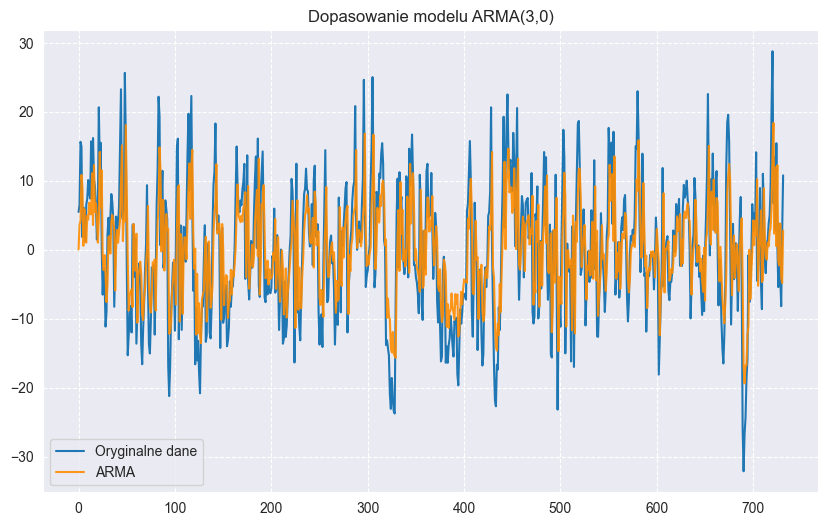

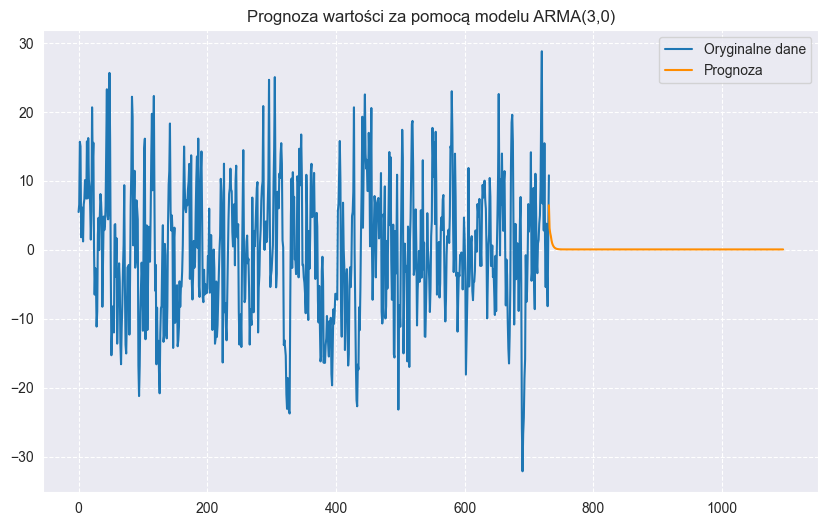

In [150]:
city_data_model = city_data.copy()

p1 = 3
q1 = 0


model = ARIMA(city_data_model, order=(p1, 0, q1))
fitted_model = model.fit(method = 'yule_walker')

fitted_values = fitted_model.predict()
# 5. Ewaluacja
print(fitted_model.summary())

# 6. Prognozowanie
forecast = fitted_model.forecast(steps=n)


# eps = np.random.normal(0,2.2,len(forecast))
# forecast += eps

plt.plot(city_data, label='Oryginalne dane')
plt.plot(fitted_values, label = 'ARMA',alpha =0.9,c='darkorange')
plt.title(f"Dopasowanie modelu ARMA({p1},{q1})")
plt.legend()
plt.grid(linestyle='--')
plt.savefig("ARMA.png")
plt.show()

t1 = np.arange(len(city_data)-1,len(city_data)-1 + n,1)

plt.plot(city_data, label='Oryginalne dane')
plt.plot(t1,forecast, label='Prognoza', color='darkorange')
plt.title(f"Prognoza wartości za pomocą modelu ARMA({p1},{q1})")
plt.legend()
plt.grid(linestyle = '--')
plt.savefig("ARMA_prognoza.png")
plt.show()

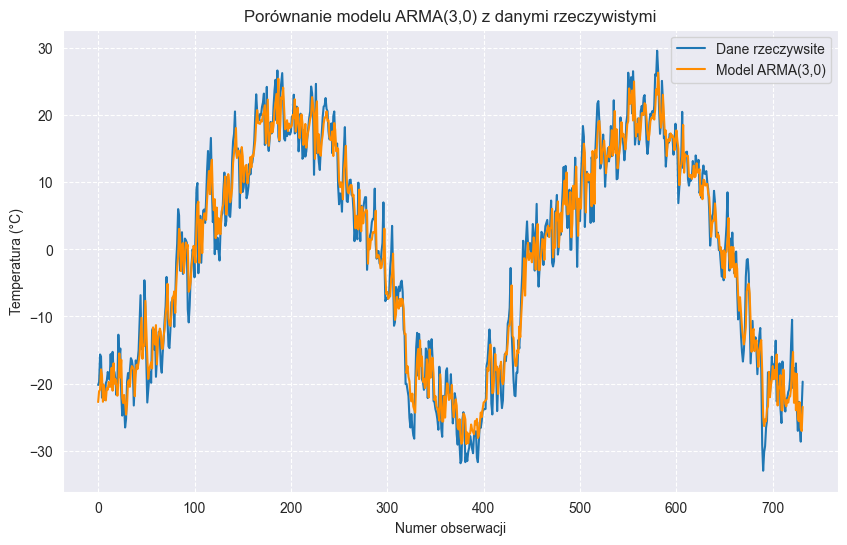

In [151]:
plt.plot(inv_boxcox(city_data +y_lin + 30,lambda_)-30+seasonal, label = 'Dane rzeczywsite')
plt.plot(inv_boxcox(fitted_values + y_lin+ 30,lambda_) - 30 +seasonal, c='darkorange', label = f'Model ARMA({p1},{q1})' )
plt.grid(linestyle = '--')
plt.xlabel('Numer obserwacji')
plt.ylabel('Temperatura (°C)')
plt.title(f'Porównanie modelu ARMA({p1},{q1}) z danymi rzeczywistymi')
plt.grid(linestyle = '--')
plt.legend()
plt.savefig("ARMA_rzeczywiste.png")
plt.show()

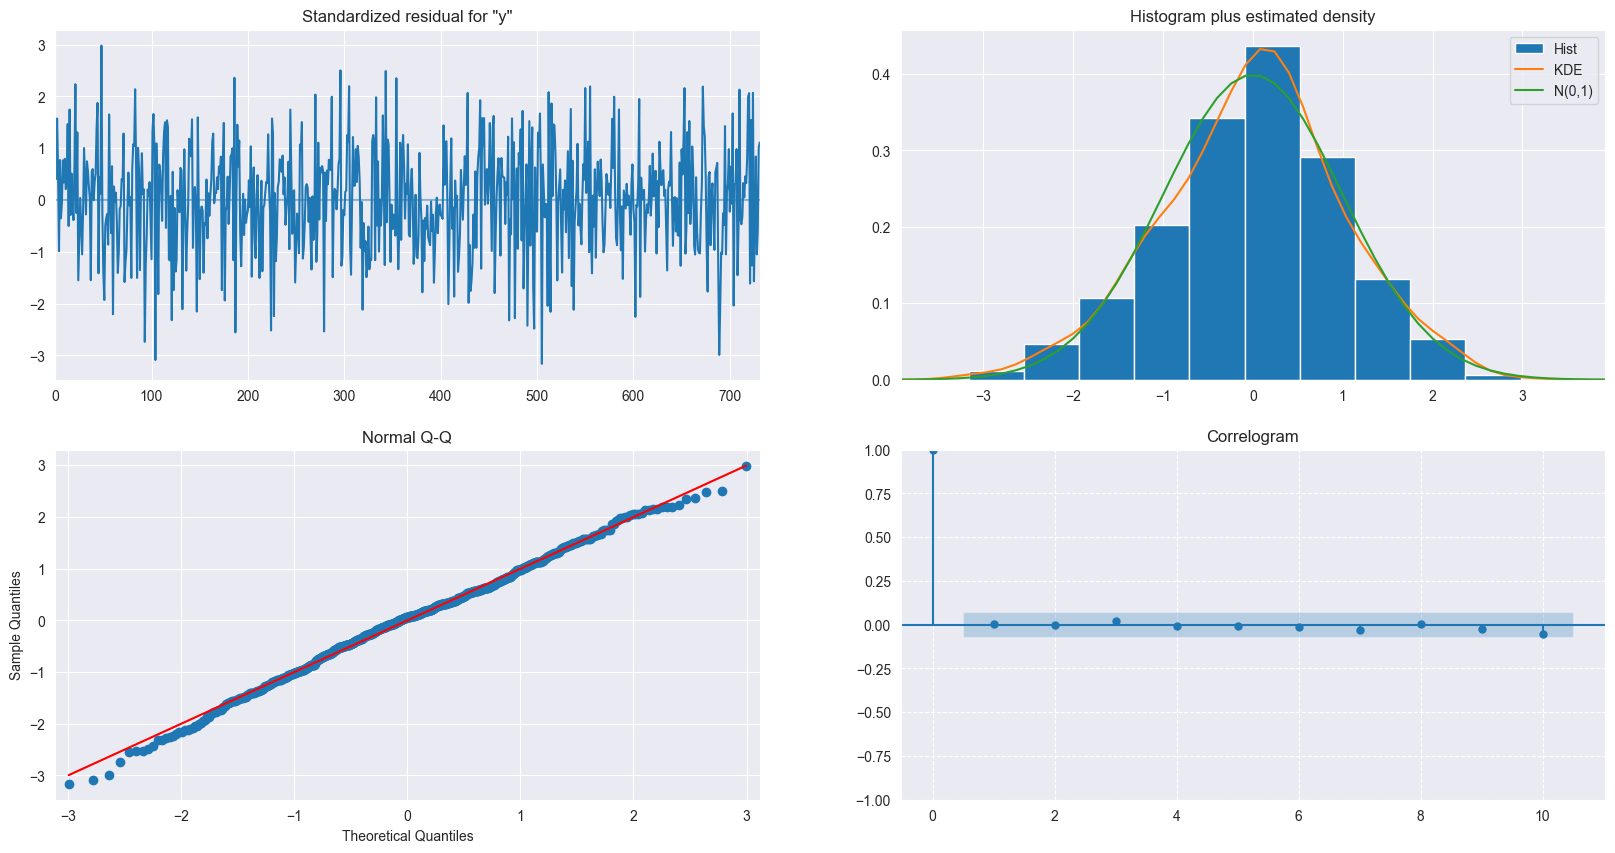

In [152]:
fitted_model.plot_diagnostics(0,figsize=(20,10))
plt.grid(linestyle='--')
plt.show()

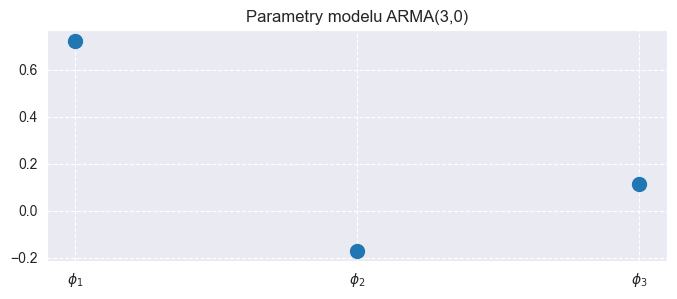

In [153]:
params = fitted_model.params

plt.figure(figsize=(8,3))
plt.plot(params[1:-1], '.', markersize=20)
plt.xticks([0, 1, 2], ['$\phi_1$', '$\phi_2$', '$\phi_3$'])
plt.grid(linestyle = '--')
plt.title(f"Parametry modelu ARMA({p1},{q1})")
plt.savefig("parametry.png")
plt.show()

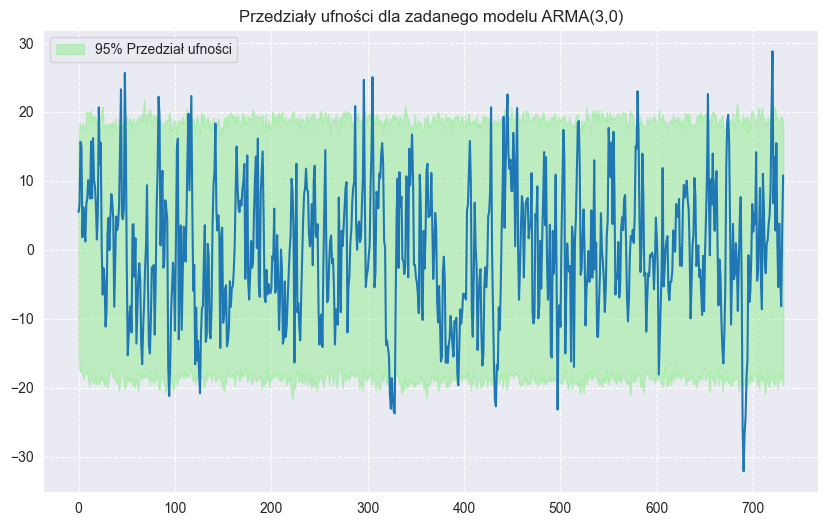

In [154]:
from statsmodels.tsa.arima_process import ArmaProcess
ar_params = fitted_model.arparams  
ma_params = fitted_model.maparams 
residuals = fitted_model.resid
sigma2 = np.var(residuals)

# Tworzenie procesu ARMA na podstawie oszacowanych parametrów
arma_process = ArmaProcess(ar=np.r_[1, -ar_params], ma=np.r_[1, ma_params])  # AR i MA muszą być w odpowiedniej formie

# Symulacja danych
n_sim = len(city_data)  # Liczba punktów czasowych
simulated_data = arma_process.generate_sample(nsample=n_sim, scale=np.sqrt(sigma2))

n_sims = 1000  # Liczba symulacji
simulated_trajectories = np.array([
    arma_process.generate_sample(nsample=n_sim, scale=np.sqrt(sigma2))
    for _ in range(n_sims)
])



# Wyznaczenie przedziałów ufności
lower_acf = np.percentile(simulated_trajectories, 2.5, axis=0)
upper_acf = np.percentile(simulated_trajectories, 97.5, axis=0)



plt.plot(city_data)
t3 = np.arange(0,len(city_data),1)
plt.fill_between(t3,lower_acf, upper_acf, color="lightgreen", alpha=0.5, label="95% Przedział ufności")
# plt.plot(t3,lower_acf,c='g')
# plt.plot(t3,upper_acf,c='g')
plt.title(f"Przedziały ufności dla zadanego modelu ARMA({p1},{q1})")
plt.legend()
plt.grid(linestyle='--')
plt.savefig("ARMA_przedzial.png")
plt.show()



## Wykres PACF i ACF dla modelu ARMA

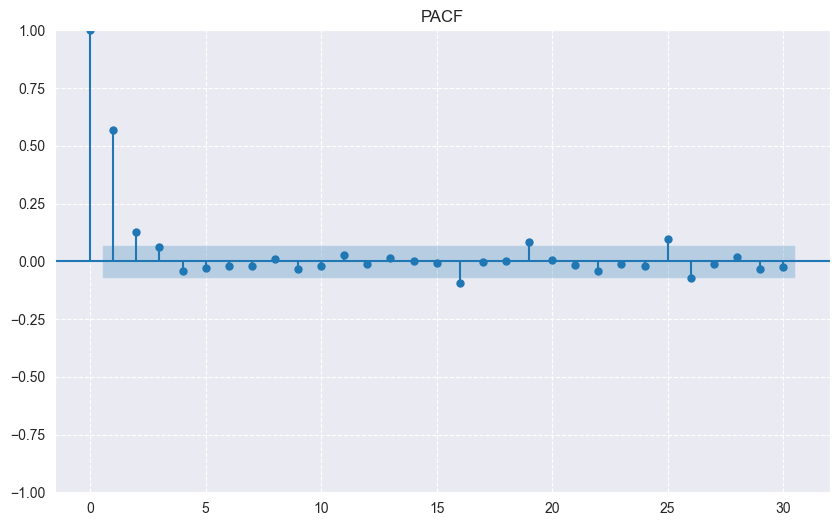

In [155]:
plt.rc("figure",figsize=(10, 6) )
plot_pacf(fitted_values, lags=30)
plt.title("PACF")
plt.grid(linestyle = '--')
plt.show()

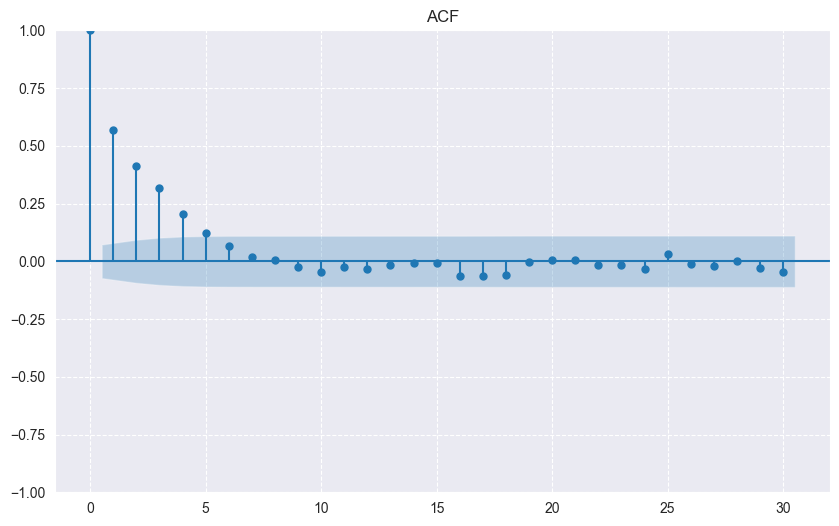

In [156]:
plt.rc("figure",figsize=(10, 6) )
plot_acf(fitted_values, lags=30)
plt.title("ACF")
plt.grid(linestyle = '--')
plt.show()

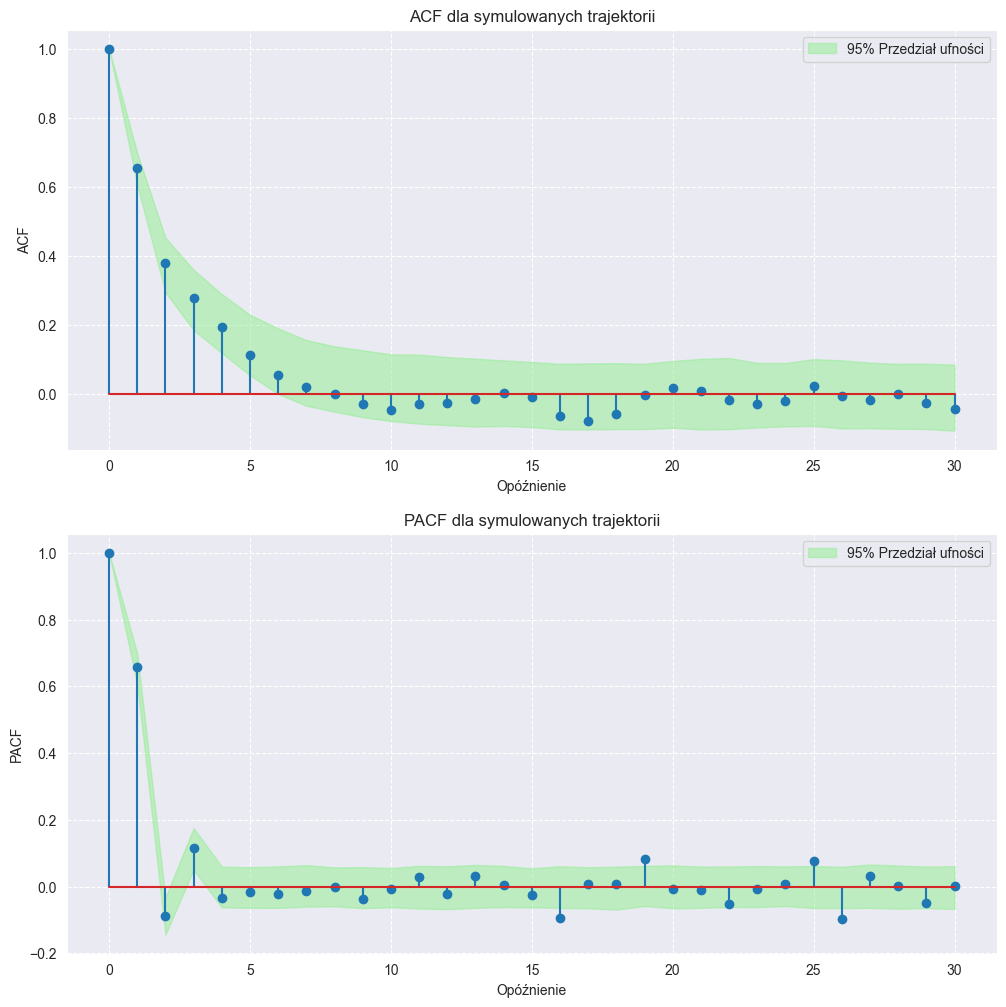

In [157]:
from statsmodels.tsa.arima_process import ArmaProcess
ar_params = fitted_model.arparams  
ma_params = fitted_model.maparams 
residuals = fitted_model.resid
sigma2 = np.var(residuals)

# Tworzenie procesu ARMA na podstawie oszacowanych parametrów
arma_process = ArmaProcess(ar=np.r_[1, -ar_params], ma=np.r_[1, ma_params])  # AR i MA muszą być w odpowiedniej formie

# Symulacja danych
n_sim = 1000  # Liczba punktów czasowych
simulated_data = arma_process.generate_sample(nsample=n_sim, scale=np.sqrt(sigma2))

n_sims = 1000  # Liczba symulacji
simulated_trajectories = np.array([
    arma_process.generate_sample(nsample=n_sim, scale=np.sqrt(sigma2))
    for _ in range(n_sims)
])

from statsmodels.tsa.stattools import acf, pacf

# Parametry
nlags = 30  # Liczba opóźnień, dla których obliczamy ACF/PACF

# Obliczanie ACF i PACF dla każdej symulacji
acf_values_sims = np.array([acf(simulated_trajectories[i], nlags=nlags, fft=True) for i in range(n_sims)])
pacf_values_sims = np.array([pacf(simulated_trajectories[i], nlags=nlags) for i in range(n_sims)])


# Wyznaczenie przedziałów ufności
lower_acf = np.percentile(acf_values_sims, 2.5, axis=0)
upper_acf = np.percentile(acf_values_sims, 97.5, axis=0)

lower_pacf = np.percentile(pacf_values_sims, 2.5, axis=0)
upper_pacf = np.percentile(pacf_values_sims, 97.5, axis=0)


lags = np.arange(0, nlags + 1)

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.stem(lags,acf(city_data,nlags=nlags))
plt.fill_between(lags, lower_acf, upper_acf, color="lightgreen", alpha=0.5, label="95% Przedział ufności")
plt.title("ACF dla symulowanych trajektorii")
plt.xlabel("Opóźnienie")
plt.ylabel("ACF")
plt.legend()
plt.grid(linestyle='--')
# plt.savefig("ARMA_ACF.png")
# plt.show()

plt.subplot(2,1,2)
# Wykres PACF
plt.stem(lags,pacf(city_data,nlags=nlags))
plt.fill_between(lags, lower_pacf, upper_pacf, color="lightgreen", alpha=0.5, label="95% Przedział ufności")
plt.title("PACF dla symulowanych trajektorii")
plt.xlabel("Opóźnienie")
plt.ylabel("PACF")
plt.legend()
plt.grid(linestyle='--')
plt.savefig("ARMA_PACF.png")
plt.show()




## Predykcja następnych wartości

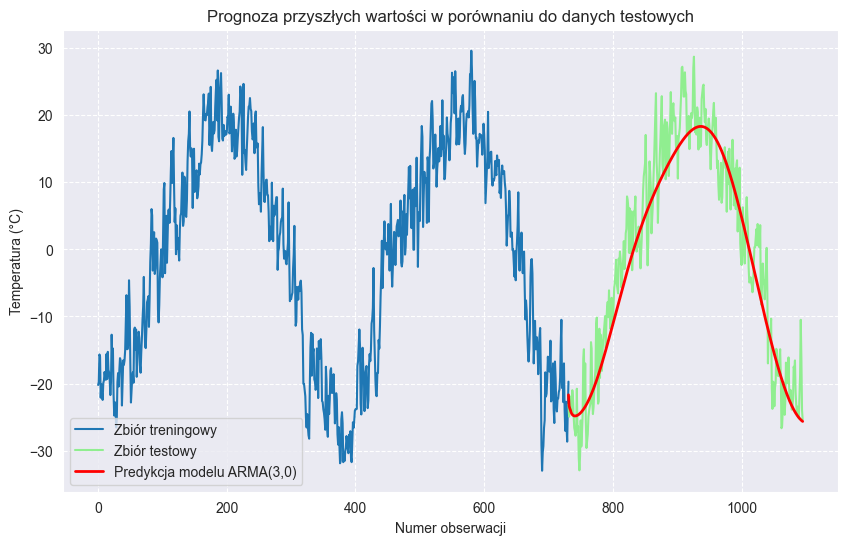

In [158]:
y_lin1 = np.polyval(lin,t1)

plt.plot(inv_boxcox(city_data + y_lin + 30,lambda_) - 30 + seasonal, label = 'Zbiór treningowy')
plt.plot(t1,future_data,alpha = 1, c = 'lightgreen', label = "Zbiór testowy")
plt.plot(t1,inv_boxcox(forecast + y_lin1 + 30, lambda_) - 30 + seasonal[:len(forecast)], c = 'r', label = f"Predykcja modelu ARMA({p1},{q1})", linewidth = 2)
plt.legend()
plt.xlabel('Numer obserwacji')
plt.ylabel('Temperatura (°C)')
plt.title(f'Prognoza przyszłych wartości w porównaniu do danych testowych')
plt.grid(linestyle = '--')
plt.savefig("ARMA_prognoza_porownanie.png")
plt.show()

## Analiza resiudum

In [159]:
residua = fitted_model.resid

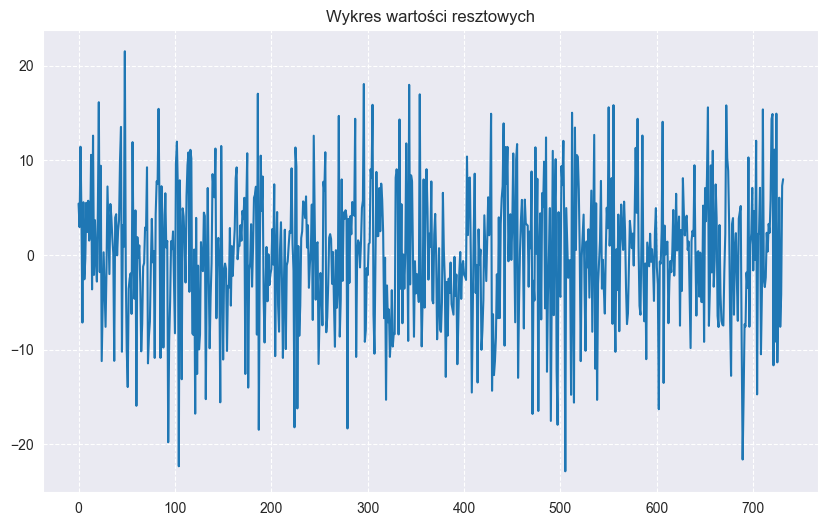

In [160]:
plt.plot(residua)
plt.grid(linestyle='--')
plt.title("Wykres wartości resztowych")
plt.savefig("reszty.png")
plt.show()

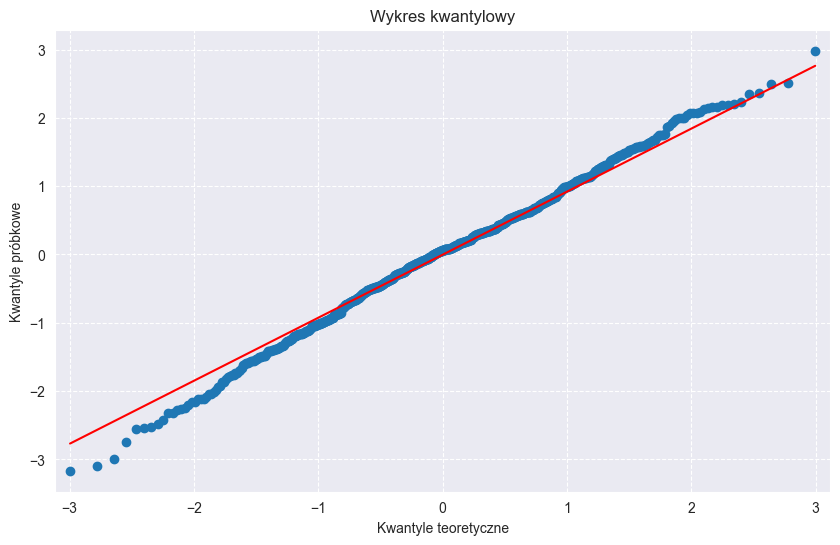

In [161]:
fig = qqplot(residua, line="q",  fit=True)
plt.grid(linestyle='--')
plt.title("Wykres kwantylowy")
plt.xlabel("Kwantyle teoretyczne")
plt.ylabel("Kwantyle próbkowe")
plt.savefig("qqplot.png")
plt.show()

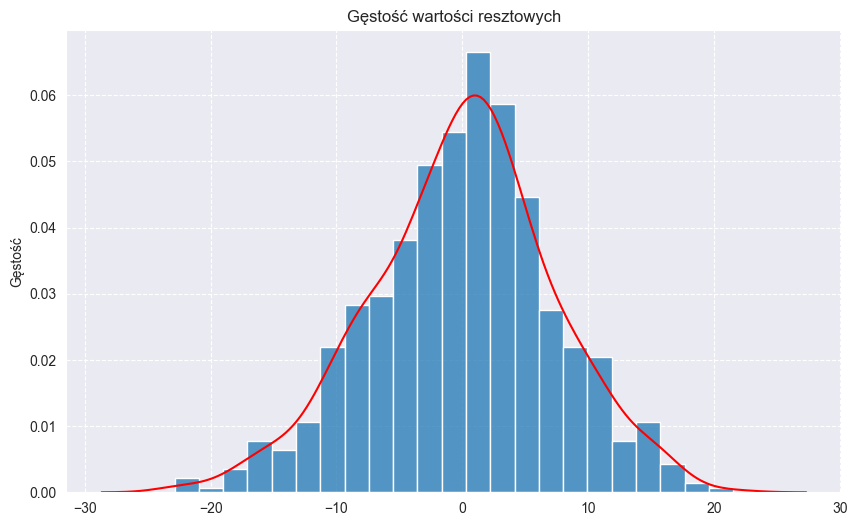

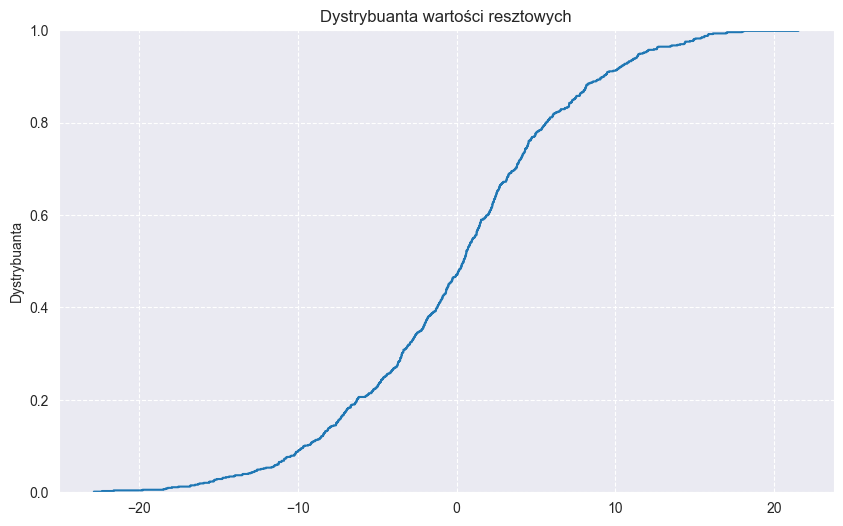

In [162]:
import seaborn as sns

sns.histplot(fitted_model.resid,stat='density')
sns.kdeplot(fitted_model.resid, c='r')
plt.grid(linestyle = '--')
plt.title("Gęstość wartości resztowych")
plt.ylabel("Gęstość")
plt.savefig("kde.png")
plt.show()

sns.ecdfplot(fitted_model.resid)
plt.title("Dystrybuanta wartości resztowych")
plt.ylabel("Dystrybuanta")
plt.grid(linestyle = '--')
plt.savefig("ecdf.png")
plt.show()

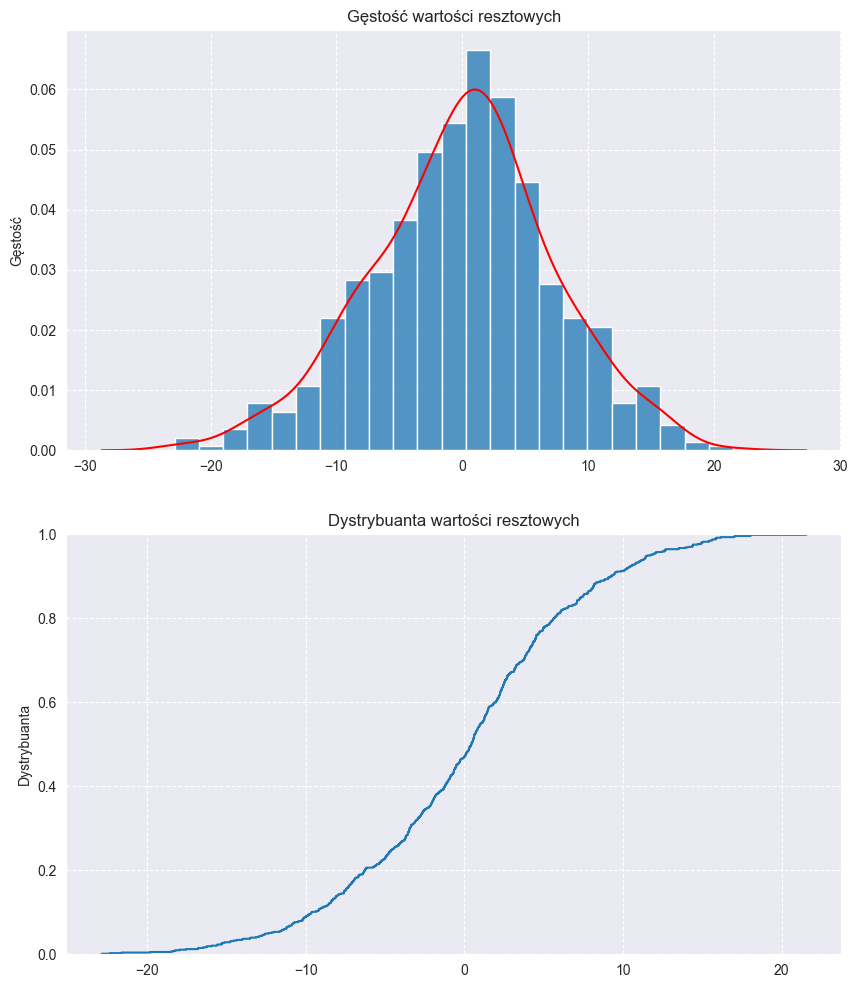

In [163]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
sns.histplot(fitted_model.resid,stat='density')
sns.kdeplot(fitted_model.resid, c='r')
plt.grid(linestyle = '--')
plt.title("Gęstość wartości resztowych")
plt.ylabel("Gęstość")

plt.subplot(2,1,2)
sns.ecdfplot(fitted_model.resid)
plt.title("Dystrybuanta wartości resztowych")
plt.ylabel("Dystrybuanta")
plt.grid(linestyle = '--')
plt.savefig("ecdf_kde.png")
plt.show()

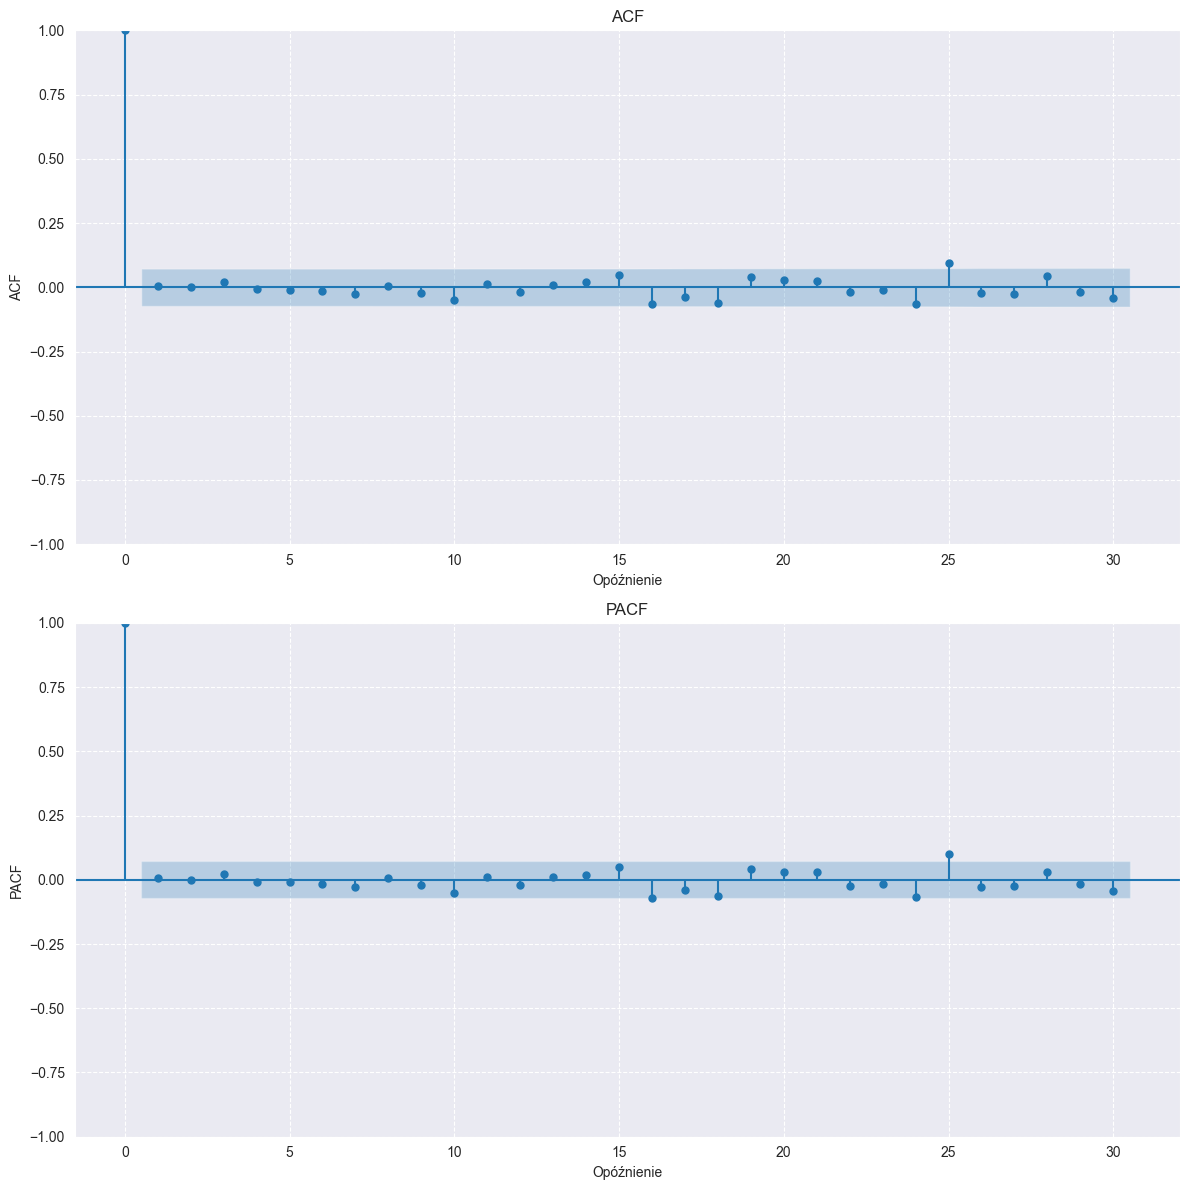

In [164]:
# Ustaw rozmiar figury
fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # 2 wiersze, 1 kolumna

# Wykres ACF
plot_acf(residua, lags=30, ax=axes[0])  # Przypisanie wykresu do pierwszej osi
axes[0].set_title("ACF")
axes[0].set_xlabel("Opóźnienie")  # Etykieta osi X dla ACF
axes[0].set_ylabel("ACF")         # Etykieta osi Y dla ACF
axes[0].grid(linestyle='--')

# Wykres PACF
plot_pacf(residua, lags=30, ax=axes[1])  # Przypisanie wykresu do drugiej osi
axes[1].set_title("PACF")
axes[1].set_xlabel("Opóźnienie")  # Etykieta osi X dla PACF
axes[1].set_ylabel("PACF")        # Etykieta osi Y dla PACF
axes[1].grid(linestyle='--')

# Automatyczne dopasowanie układu i wyświetlenie
plt.savefig("PACF_ACF_residua.png")
plt.tight_layout()
plt.show()

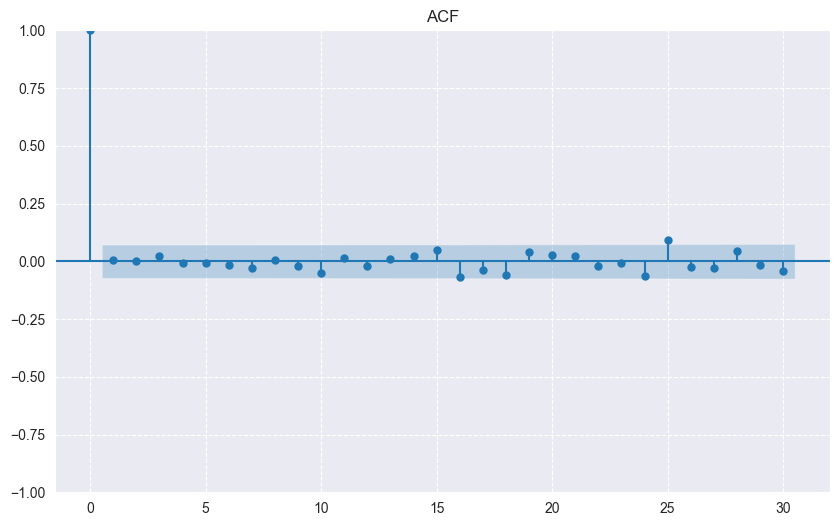

In [165]:
plt.rc("figure",figsize=(10, 6) )
plot_acf(residua, lags=30)
plt.title("ACF")
plt.grid(linestyle = '--')
plt.savefig("ACF_residua.png")
plt.show()

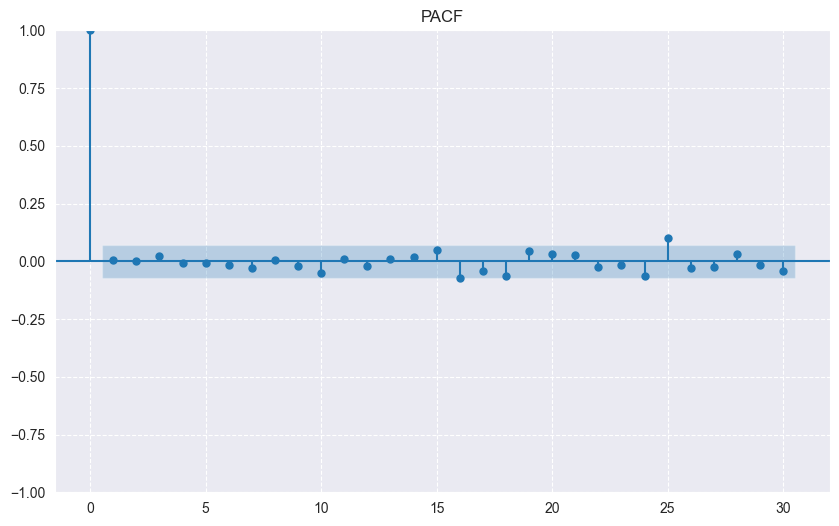

In [166]:

plt.rc("figure",figsize=(10, 6) )
plot_pacf(residua, lags=30)
plt.title("PACF")
plt.grid(linestyle = '--')
plt.savefig("PACF_residua.png")
plt.show()

In [167]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(residua, lags=[25], return_df=True)


,lb_stat,lb_pvalue
25,25.714553,0.422954


In [168]:
from scipy.stats import ttest_1samp
stat, p = ttest_1samp(residua, popmean=0)
print(stat,p)

-0.025984292779484282 0.9792769583916391


In [169]:
from scipy.stats import shapiro

stat, p_value = shapiro(residua)

# Wyniki testu
print(f"Statystyka Shapiro-Wilka: {stat}")
print(f"P-wartość: {p_value}")

# Wniosek
alpha = 0.05  # Poziom istotności
if p_value > alpha:
    print("Nie można odrzucić hipotezy zerowej: Dane mają rozkład normalny.")
else:
    print("Odrzucamy hipotezę zerową: Dane nie mają rozkładu normalnego.")

Statystyka Shapiro-Wilka: 0.9963539104276632
P-wartość: 0.0898110675684491
Nie można odrzucić hipotezy zerowej: Dane mają rozkład normalny.


In [170]:
from statsmodels.stats.diagnostic import het_arch

p_value = het_arch(residua)
print(p_value[1])

0.3659020464193405


In [171]:
print(np.mean(residua))

-0.0069438546654934765
